In [22]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense, Flatten, BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

In [24]:
generate_res = 3
generate_square = 32 * generate_res
channels = 3

preview_rows = 4
preview_cols = 7
preview_margin = 16

seed_size = 100
data_path = '/content/drive/My Drive/images'
epochs = 100
batch_size = 32
buffer_size = 60000

print(f"We'll generate {generate_square}px square images")

We'll generate 96px square images


In [25]:
training_binary_path = os.path.join(data_path, f"training_data_{generate_square}_{generate_square}.npy")
print(f"looking for file {training_binary_path} ")

looking for file /content/drive/My Drive/images/training_data_96_96.npy 


In [26]:
if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  faces_path = os.path.join(data_path,'images')
  for filename in tqdm(os.listdir(faces_path)):
      path = os.path.join(faces_path,filename)
      image = Image.open(path).resize((generate_square, generate_square),Image.ANTIALIAS)
      training_data.append(np.asarray(image))
  training_data = np.reshape(training_data,(-1,generate_square,generate_square,channels))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
  elapsed = time.time()-start
  print (f'Image preprocess time: {hms_string(elapsed)}')
else:
  print("Loading previous training pickle...")
  training_data = np.load(training_binary_path)

Loading previous training pickle...


In [0]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(training_data).shuffle(buffer_size).batch(batch_size)

In [0]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if generate_res >1:
      model.add(UpSampling2D(size=(generate_res,generate_res)))
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model


In [0]:
def build_discriminator(image_shape): 
  model = Sequential()
  model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.25))
  model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
  model.add(ZeroPadding2D(padding=((0,1),(0,1))))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.25))
  model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.25))
  model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.25))
  model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  return model

In [0]:
def save_images(cnt,noise):
  image_array = np.full(( 
      preview_margin + (preview_rows * (generate_square+preview_margin)), 
      preview_margin + (preview_cols * (generate_square+preview_margin)), 3), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(preview_rows):
      for col in range(preview_cols):
        r = row * (generate_square+16) + preview_margin
        c = col * (generate_square+16) + preview_margin
        image_array[r:r+generate_square,c:c+generate_square] = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(data_path,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)



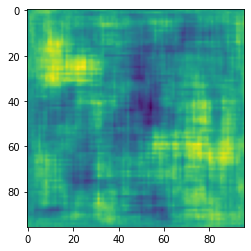

In [31]:
generator = build_generator(seed_size, channels)

noise = tf.random.normal([1, seed_size])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [32]:
image_shape = (generate_square,generate_square,channels)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.5005785]], shape=(1, 1), dtype=float32)


In [0]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

In [0]:
@tf.function
def train_step(images):
  seed = tf.random.normal([batch_size, seed_size])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  return gen_loss,disc_loss

In [0]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (preview_rows * preview_cols, seed_size))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}, {epoch_elapsed}')
    save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {elapsed}')

In [0]:
train(train_dataset, epochs)

Epoch 1, gen loss=0.6647637486457825,disc loss=1.2668447494506836, 33.99927043914795
Epoch 2, gen loss=0.6781848073005676,disc loss=1.2741869688034058, 28.38714623451233


In [0]:
generator.save(os.path.join(data_path,"face_generator.h5"))